# Sun Spot Activity

Monthly Mean Total Sunspot Number - form January 1749 to December 2019.

269 years, 3252 months of data.

In [1]:
import kaggle #api token file required
import os
import shutil
import zipfile
import pandas as pd
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Download, Unzip, Load

In [2]:
!kaggle datasets download -d robervalt/sunspots

# target folder
local_zip = f'{os.getcwd()}\\Data\\sunspots.zip'

# cut and paste
shutil.move(f'{os.getcwd()}\\sunspots.zip', local_zip)


  0%|          | 0.00/22.4k [00:00<?, ?B/s]
100%|##########| 22.4k/22.4k [00:00<00:00, 802kB/s]


'C:\\Users\\ChristianV700\\Documents\\GitHub\\DataScienceProjects\\Data\\sunspots.zip'

In [3]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f'{os.getcwd()}\\data')
zip_ref.close()

In [4]:
pd.read_csv(f'{os.getcwd()}\\data\\sunspots.csv')

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3247,3247,2019-08-31,0.5
3248,3248,2019-09-30,1.1
3249,3249,2019-10-31,0.4
3250,3250,2019-11-30,0.5


## Step 2: Read csv and Explore

In [5]:
time_step = []
sunspots = []

with open(f'{os.getcwd()}\\Data\\sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # the next() function skips the first line (header) when looping
  for row in reader:
    sunspots.append(float(row[2])) # sun spot value cast to float
    time_step.append(int(row[0]))  # the index of the csv gets read into time_step variable

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    myplot = plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (months since Jan 1749)")
    plt.ylabel("Average monthly Sun Spots")
    plt.grid(True)

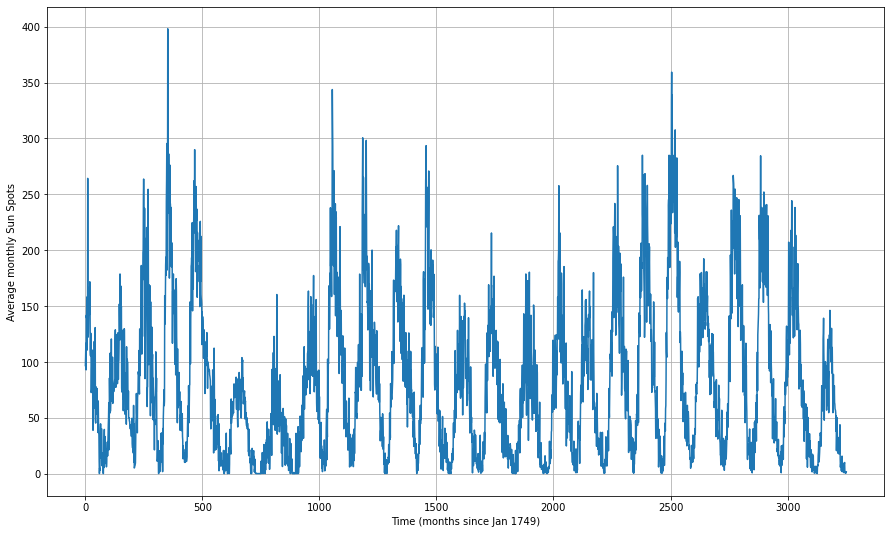

In [7]:
series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(15, 9))
plot_series(time, series)

## Step 3: Pre-Processing
### Split into Test and Validation Sets

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# the window size is important for training results
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

### Helper function for slicing data into time-series windows

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Step 4: Train for Learning Rate Optimization

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


Text(0, 0.5, 'Loss')

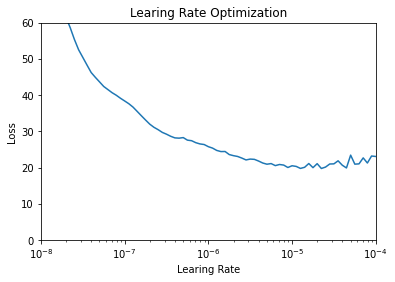

In [11]:
# pick 
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.title('Learing Rate Optimization')
plt.xlabel("Learing Rate")
plt.ylabel("Loss")

## Step 5: Train with Optimized Learning Rate

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=500, verbose=0)

## Step 6: Forecasting and Evaluating

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

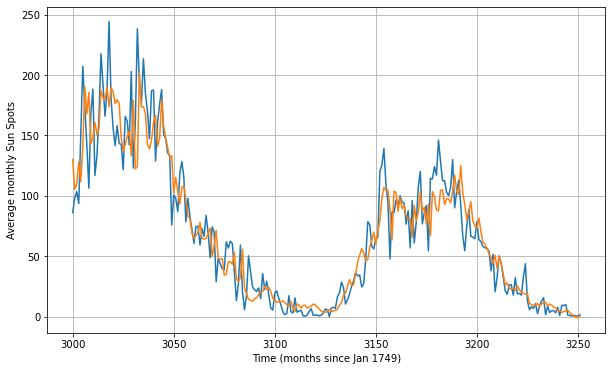

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
print('Mean Absolute Error (MAE): ',tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

Mean Absolute Error (MAE):  14.468494


<Figure size 432x288 with 0 Axes>

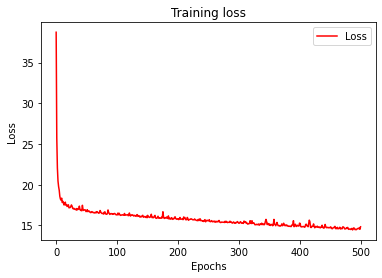

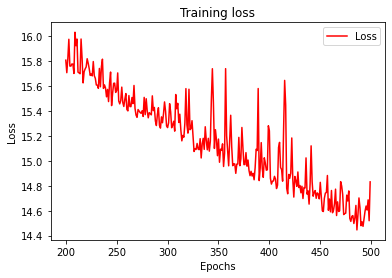

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(len(loss))

# full graph
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

# zoomed graph
zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()

In [18]:
print(rnn_forecast)

[ 1.30060577e+02  1.05348518e+02  1.09381195e+02  1.28054886e+02
  1.11583672e+02  1.40004822e+02  1.90222061e+02  1.67824249e+02
  1.85565430e+02  1.43169312e+02  1.48107956e+02  1.60880981e+02
  1.50721039e+02  1.55593445e+02  1.87307159e+02  1.80971786e+02
  1.80160522e+02  1.89611191e+02  1.73717880e+02  1.89517853e+02
  1.86163330e+02  1.76234406e+02  1.79587341e+02  1.76291321e+02
  1.48432526e+02  1.36885559e+02  1.42226990e+02  1.49199249e+02
  1.53405792e+02  1.32975845e+02  1.78953766e+02  1.22231308e+02
  1.24327316e+02  2.02095978e+02  1.73603012e+02  1.73765732e+02
  1.68228867e+02  1.42690506e+02  1.38610153e+02  1.45970337e+02
  1.60778885e+02  1.66425919e+02  1.40959457e+02  1.47493301e+02
  1.79708450e+02  1.57554749e+02  1.48237259e+02  1.39782181e+02
  1.31198059e+02  1.33159775e+02  1.02437653e+02  1.15158333e+02
  1.03993568e+02  9.30369644e+01  1.07193665e+02  1.08111015e+02
  9.68970566e+01  8.32839737e+01  8.10505981e+01  6.92733994e+01
  6.46178970e+01  6.73422